<a href="https://colab.research.google.com/github/LaurenVaught/HouseRegression/blob/main/House_Price_Regression_Prediction_Ames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impute

In [ ]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error


In [ ]:
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
import xgboost as xg
#from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving housetest.csv to housetest.csv
Saving housetrain.csv to housetrain.csv


In [ ]:
import io
train = pd.read_csv(io.BytesIO(uploaded['housetrain.csv']))
test = pd.read_csv(io.BytesIO(uploaded['housetest.csv']))
# Dataset is now stored in a Pandas Dataframe

# EDA

In [ ]:
train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856,GasA,Ex,Y,SBrkr,856,1710,2,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,NaN,NaN,NaN,WD,Normal,208500
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262,GasA,Ex,Y,SBrkr,1262,1262,2,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,NaN,NaN,NaN,WD,Normal,181500
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920,GasA,Ex,Y,SBrkr,920,1786,2,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,NaN,NaN,NaN,WD,Normal,223500
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,756,GasA,Gd,Y,SBrkr,961,1717,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,140000
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145,GasA,Ex,Y,SBrkr,1145,2198,2,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,NaN,NaN,NaN,WD,Normal,250000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   Street         1460 non-null   object 
 2   Alley          91 non-null     object 
 3   LotShape       1460 non-null   object 
 4   LandContour    1460 non-null   object 
 5   Utilities      1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  Condition2     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  OverallQual    1460 non-null   int64  
 14  YearBuilt      1460 non-null   int64  
 15  YearRemodAdd   1460 non-null   int64  
 16  RoofStyle      1460 non-null   object 
 17  RoofMatl       1460 non-null   object 
 18  Exterior

In [ ]:
#missing values
total = train.isnull().sum().sort_values(ascending = False)[train.isnull().sum().sort_values(ascending = False) != 0]
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)[(train.isnull().sum() / train.isnull().count()).sort_values(ascending = False) != 0]
missing = pd.concat([total, percent], axis = 1, keys = ['Total Missing', 'Percent Missing'])
print(missing)

              Total Missing  Percent Missing
PoolQC                 1453         0.995205
MiscFeature            1406         0.963014
Alley                  1369         0.937671
Fence                  1179         0.807534
FireplaceQu             690         0.472603
GarageCond               81         0.055479
GarageQual               81         0.055479
GarageFinish             81         0.055479
GarageYrBlt              81         0.055479
GarageType               81         0.055479
BsmtExposure             38         0.026027
BsmtFinType2             38         0.026027
BsmtFinType1             37         0.025342
BsmtQual                 37         0.025342
BsmtCond                 37         0.025342
MasVnrType                8         0.005479
MasVnrArea                8         0.005479
Electrical                1         0.000685


In [ ]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
def plotting_3_chart(train, feature):
    style.use("fivethirtyeight")
    
    fig = plt.figure(constrained_layout = True, figsize = (15, 8))#constrained_layout:auto adjust object placement.
    grid = gridspec.GridSpec(ncols = 3, nrows = 2, figure = fig)
    
    #Histogram
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(train.loc[:, feature], norm_hist = True, ax = ax1, color = 'g')
    
    #Probability Plot
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Probability Plot')
    stats.probplot(train.loc[:, feature], plot = ax2)
    
    #Box Plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(train.loc[:, feature], orient = 'v', ax = ax3)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


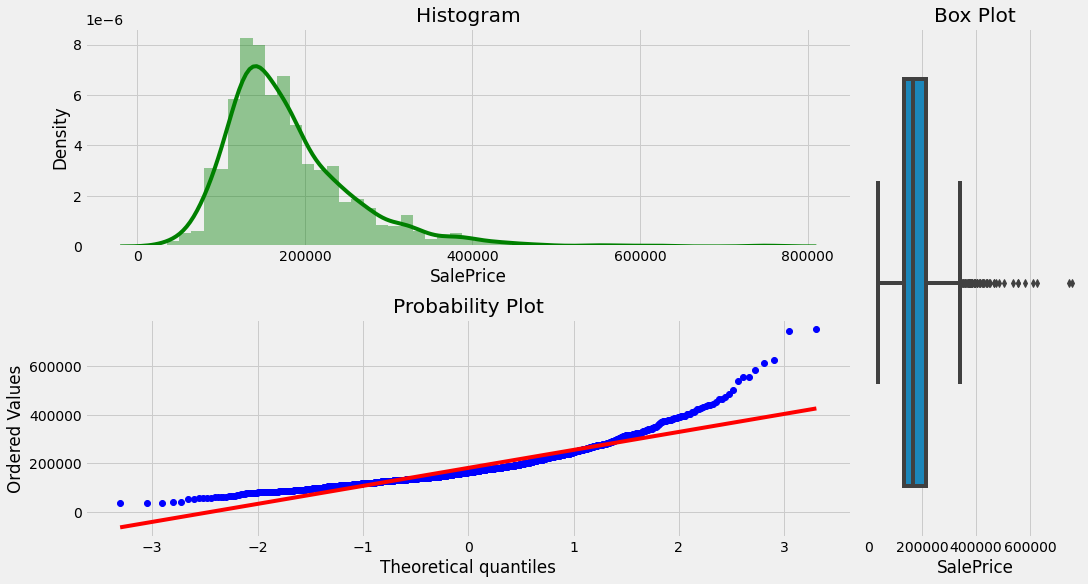

In [ ]:
plotting_3_chart(train, 'SalePrice')

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.50,1464.0,1776.75,5642.0
FullBath,1460.0,1.565068,0.550916,0.0,1.00,2.0,2.00,3.0
TotRmsAbvGrd,1460.0,6.517808,1.625393,2.0,5.00,6.0,7.00,14.0
Fireplaces,1460.0,0.613014,0.644666,0.0,0.00,1.0,1.00,3.0


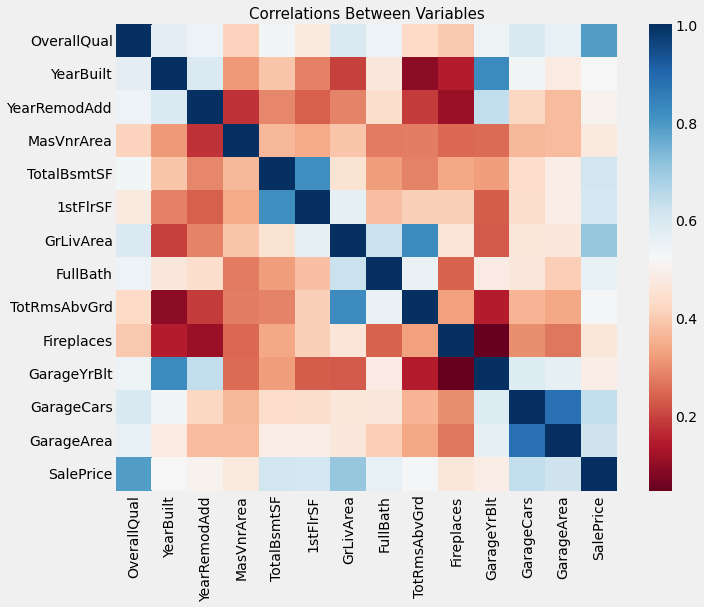

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [ ]:
def select_cols_corr(df_corr, target_col, min_corr, max_corr): 
    #creating df target_corr
    target_corr = df_corr[target_col].reset_index()
    return target_corr.loc[(target_corr.iloc[:,1] < max_corr) & (target_corr.iloc[:,1] > min_corr),:]

select_cols_corr(train.corr(), 'SalePrice', min_corr=.4, max_corr=.95)

,index,SalePrice
4,OverallQual,0.790982
6,YearBuilt,0.522897
7,YearRemodAdd,0.507101
8,MasVnrArea,0.477493
12,TotalBsmtSF,0.613581
13,1stFlrSF,0.605852
16,GrLivArea,0.708624
19,FullBath,0.560664
23,TotRmsAbvGrd,0.533723
24,Fireplaces,0.466929


In [ ]:
num_col = select_cols_corr(train.corr(), 'SalePrice', min_corr=.4, max_corr=.95).iloc[:,0].tolist()

In [ ]:
cat_col = train.select_dtypes(include=["object"]).columns.to_list()

In [ ]:
#dropping columns except numerical, categorical, and 'SalePrice'
train.drop(train.columns.difference(cat_col + num_col + ['SalePrice']), axis=1, inplace=True)

In [ ]:
#check for missing values
print("Missing Values by Column")
print("-"*30)
print(train.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",train.isna().sum().sum())

Missing Values by Column
------------------------------
MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
GrLivArea           0
FullBath            0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       69

In [ ]:
important_num_cols = list(train.corr()["SalePrice"][(train.corr()["SalePrice"]>0.50) | (train.corr()["SalePrice"]<-0.50)].index)

cat_cols = ["MSZoning", "Utilities","BldgType","Heating","KitchenQual","SaleCondition","LandSlope"]

important_cols = important_num_cols + cat_cols

df = train[important_cols]

In [ ]:
#check for missing values
print("Missing Values by Column")
print("-"*30)
print(df.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",df.isna().sum().sum())

Missing Values by Column
------------------------------
OverallQual      0
YearBuilt        0
YearRemodAdd     0
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
TotRmsAbvGrd     0
GarageCars       0
GarageArea       0
SalePrice        0
MSZoning         0
Utilities        0
BldgType         0
Heating          0
KitchenQual      0
SaleCondition    0
LandSlope        0
dtype: int64
------------------------------
TOTAL MISSING VALUES: 0


<Figure size 720x576 with 0 Axes>

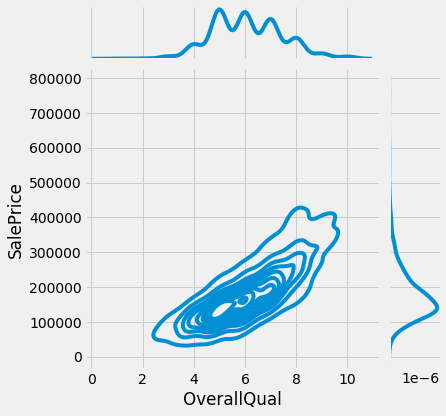

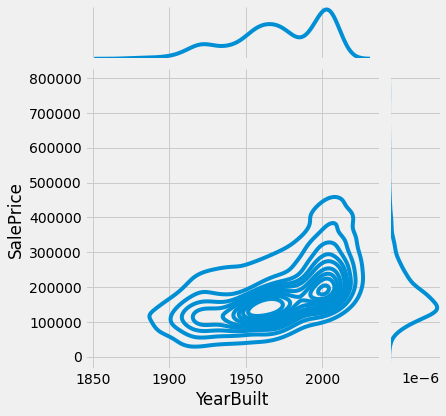

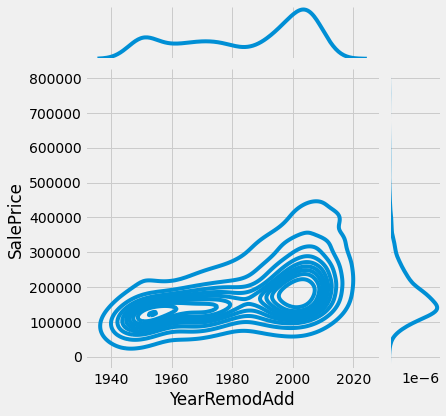

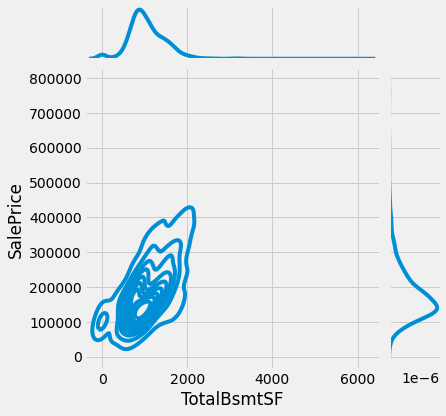

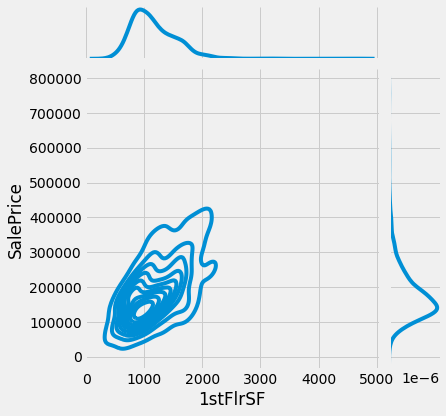

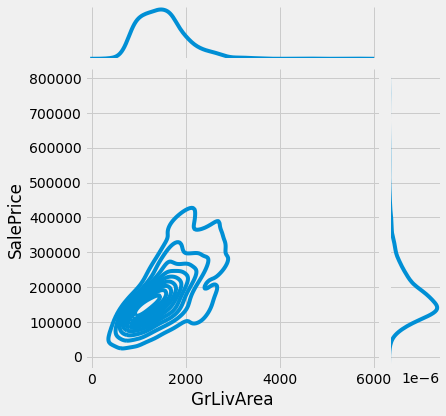

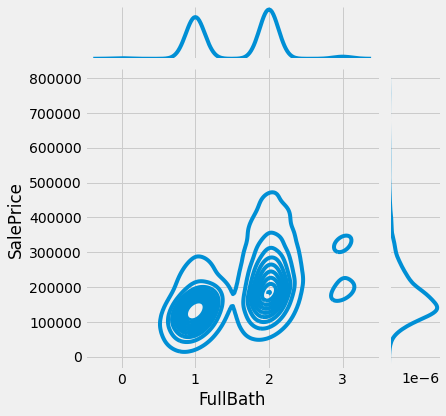

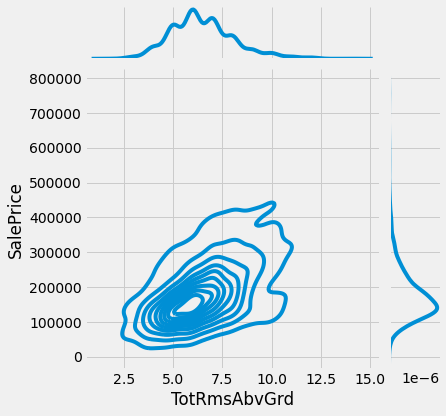

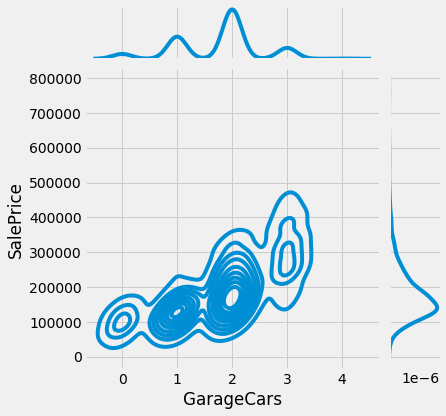

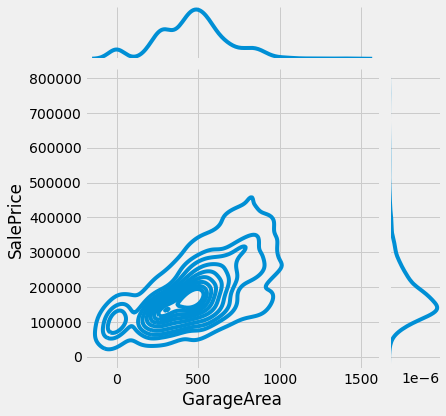

In [ ]:
plt.figure(figsize=(10,8))
sns.jointplot(x=df["OverallQual"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["YearBuilt"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["YearRemodAdd"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["TotalBsmtSF"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["1stFlrSF"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["GrLivArea"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["FullBath"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["TotRmsAbvGrd"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["GarageCars"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["GarageArea"], y=df["SalePrice"], kind="kde")
plt.show()

Create a Feature: GrLivGarageArea

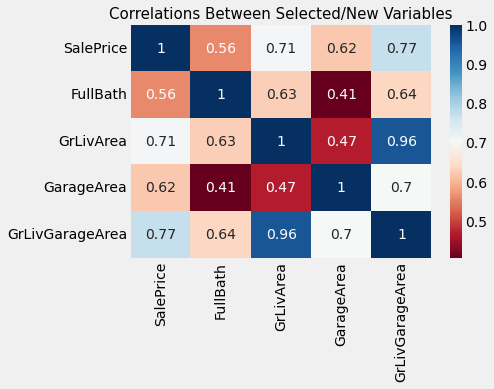

In [ ]:
# Create a new feature with GrLivArea plus garage per EDA. 
train['GrLivGarageArea'] = train['GrLivArea'] + train['GarageArea']

# Check the correlation between SalePrice, the new variable, and the previous selected variables
sns.heatmap(train[['SalePrice', "FullBath" , 'GrLivArea', 'GarageArea', 'GrLivGarageArea']].corr(), cmap="RdBu", annot=True)
plt.title("Correlations Between Selected/New Variables", size=15)
plt.show()


# Modeling

Linear Regression

In [ ]:
#split into train and test sets

X = train.drop(columns=['SalePrice'], axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
# Categorical pipeline - filling the missing values in categorical columns using SimpleImputer and OneHotEncoder. 
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot_enc', OneHotEncoder(drop='first'))
])

# Numerical pipeline - filling the missing values in numerical columns using SimpleImputer and scaling with MinMaxScaler to preserve the shape of the original distribution. 
num_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

full_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, num_col), 
    ('category', cat_pipeline, cat_col)
])

lin_model_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', LinearRegression())
])

lm = lin_model_pipeline.fit(X_train, y_train)

In [ ]:
lin_model_pipeline.named_steps.model.get_params()


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}


        MSE: 411059007.50333583
        RMSE: 20274.59019322797
        MAE: 13869.512712935768
        R_SQR: 0.9381634696606432
        EXV: 0.9381634696606432
        ME: 147502.4166877704
        RMSLE: 0.11258749191759747
        
744999.9148033585 34900


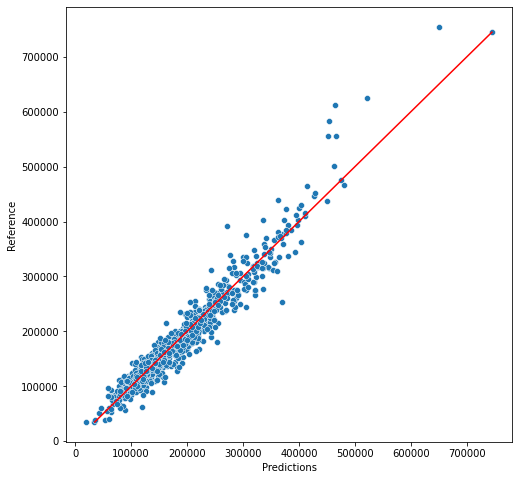

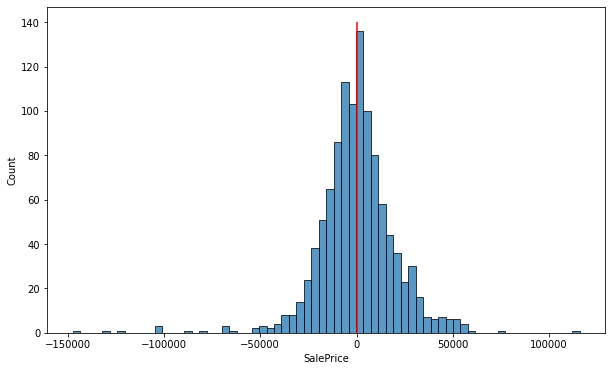

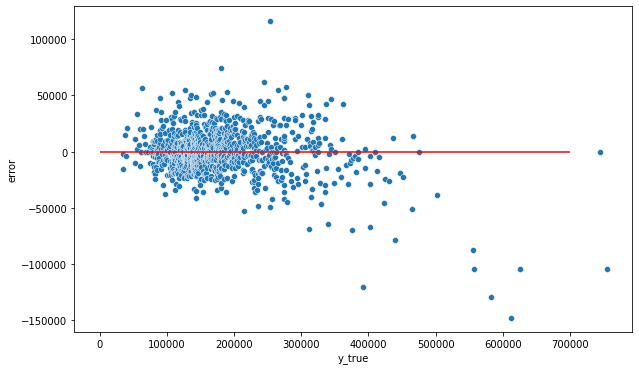

In [ ]:
def plot_predictions(y_true, y_pred):
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        R_SQR: {r2_score(y_true, y_pred)}
        EXV: {explained_variance_score(y_true, y_pred)}
        ME: {max_error(y_true, y_pred)}
        RMSLE: {mean_squared_log_error(y_true, y_pred)**0.5}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()
    
    errors = y_pred - y_true
    plt.subplots(figsize=(10, 6))
    sns.histplot(errors)
    plt.vlines(x = 0, ymin = 0, ymax = 140, color = 'red')
    plt.show()
    
    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by = 'y_true')
        )
    
    plt.subplots(figsize = (10, 6))
    sns.scatterplot(data=p_df, x = 'y_true', y = 'error')
    plt.hlines(y = 0, xmin = 0, xmax = 700000, color = 'red')
    plt.show()
    
plot_predictions(y_train, lin_model_pipeline.predict(X_train))


In [ ]:
lm_test = lin_model_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': lin_model_pipeline.predict(X_test), 
    'true_value': y_test ,
    'difference': y_test - lin_model_pipeline.predict(X_test),
})

results.head()

,prediction,true_value,difference
1260,184221.836250,181000,-3221.836250
274,133581.975984,124500,-9081.975984
51,126151.965160,114500,-11651.965160
117,159886.003433,155000,-4886.003433
789,203711.987715,187500,-16211.987715



        MSE: 213587735.2307506
        RMSE: 14614.641125622982
        MAE: 10174.660780386946
        R_SQR: 0.9593274266173751
        EXV: 0.9593274266173751
        ME: 78488.95178677607
        RMSLE: 0.08299838949672418
        
531319.6375966498 55000.01018255577


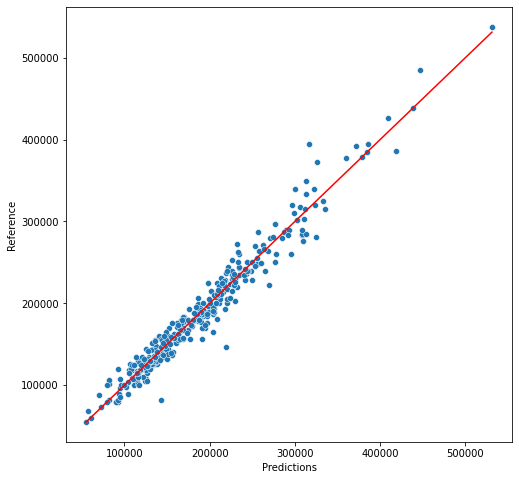

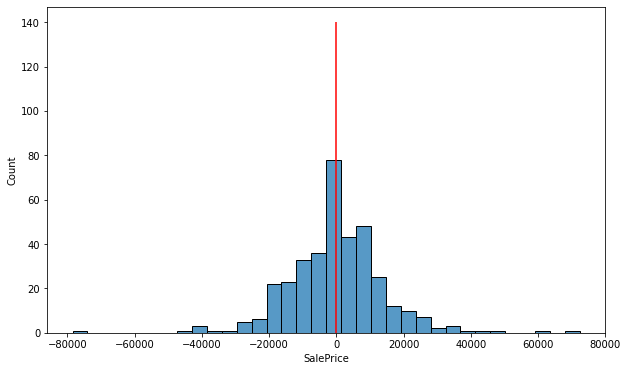

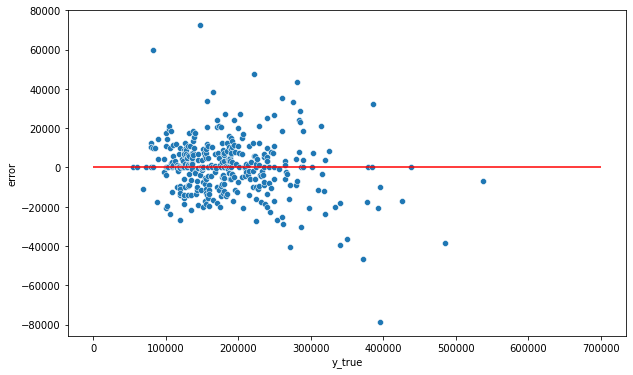

In [ ]:
plot_predictions(y_test, lin_model_pipeline.predict(X_test))

In [ ]:
coef_lr = pd.DataFrame(lin_model_pipeline['model'].coef_)
coef_lr

,0
0,86297.184099
1,47870.074715
2,15438.413146
3,-8390.944705
4,70107.786677
...,...
187,-4670.285142
188,28096.732109
189,-22166.651357
190,6828.313970


In [ ]:
intercept_lr = lin_model_pipeline['model'].intercept_
intercept_lr

51325.17557678334

Logarithmic Transformation: Random Forest Regression

In [ ]:
rf_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', RandomForestRegressor())
])

rf = rf_pipeline.fit(X_train, y_train)


        MSE: 146182905.680602
        RMSE: 12090.612295520936
        MAE: 6865.747240487063
        R_SQR: 0.9780093769575393
        EXV: 0.978010795540129
        ME: 197756.56
        RMSLE: 0.06419566187122618
        
677603.79 46812.26


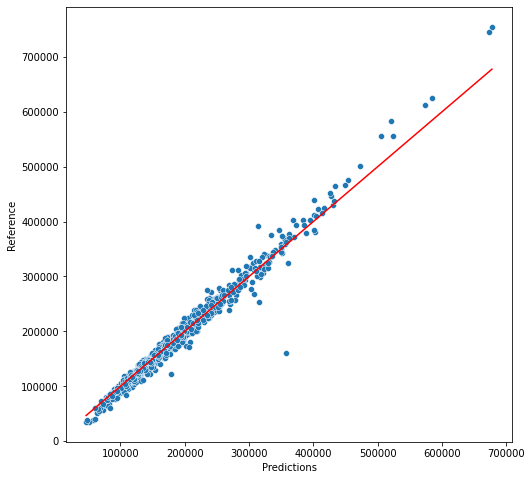

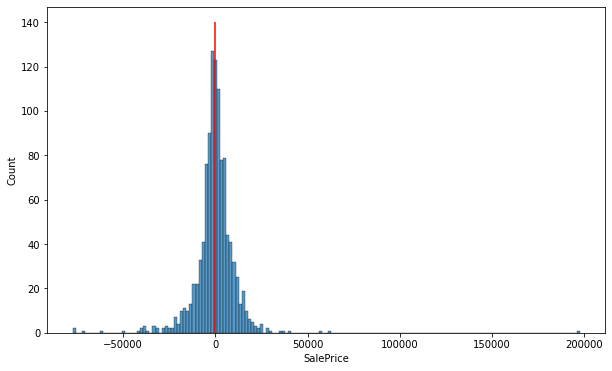

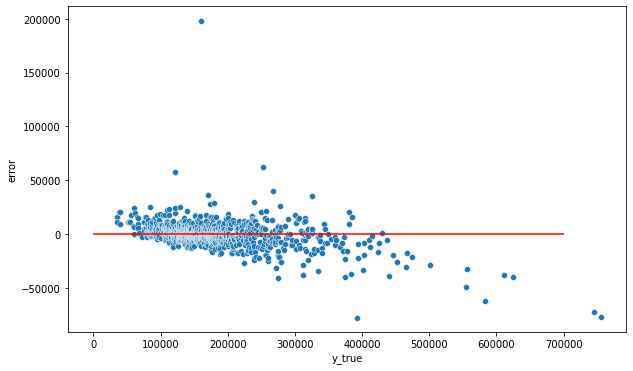

In [ ]:
plot_predictions(y_train, rf_pipeline.predict(X_train))

In [ ]:
rf_test = rf_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': rf_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - rf_pipeline.predict(X_test),
})

results.head()

,prediction,true_value,difference
1260,185286.00,181000,-4286.00
274,125035.00,124500,-535.00
51,113620.51,114500,879.49
117,156982.00,155000,-1982.00
789,195818.50,187500,-8318.50



        MSE: 149221389.04479894
        RMSE: 12215.620698302602
        MAE: 7523.743726027397
        R_SQR: 0.9715844269352597
        EXV: 0.9716118008543743
        ME: 91796.69
        RMSLE: 0.06663402370137354
        
474051.15 70881.0


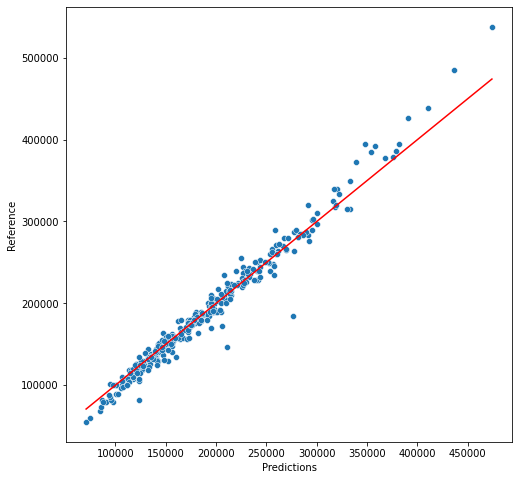

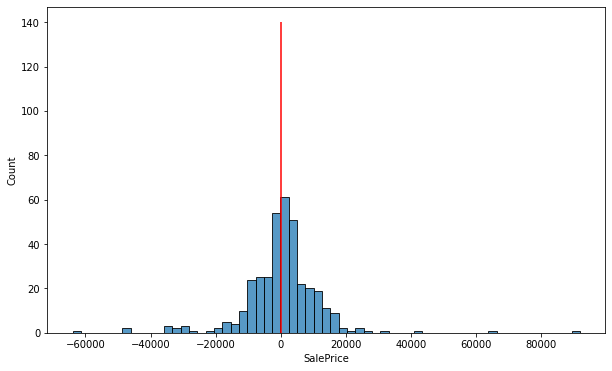

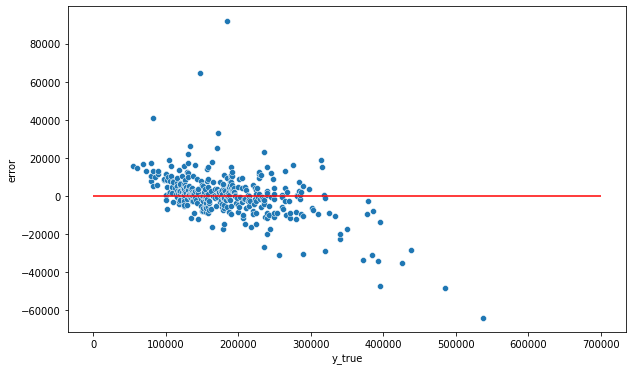

In [ ]:
plot_predictions(y_test, rf_pipeline.predict(X_test))

Ridge Regression

In [ ]:
ridge_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', Ridge())
])

rd = ridge_pipeline.fit(X_train, y_train)


        MSE: 594558882.7568368
        RMSE: 24383.578136869837
        MAE: 16015.339341686707
        R_SQR: 0.9105591710167575
        EXV: 0.9105591710167577
        ME: 260981.2872974649
        RMSLE: 0.1245649989998451
        
601948.2479576308 34900


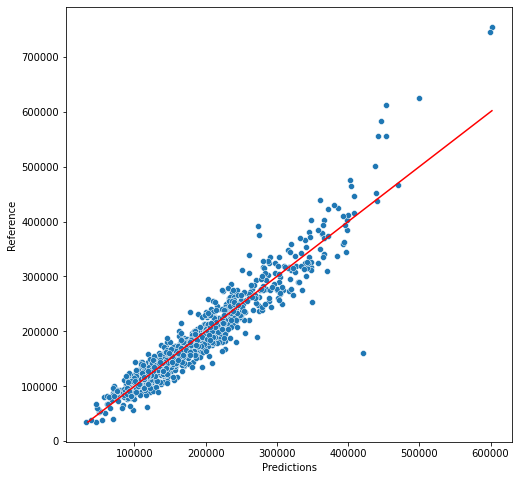

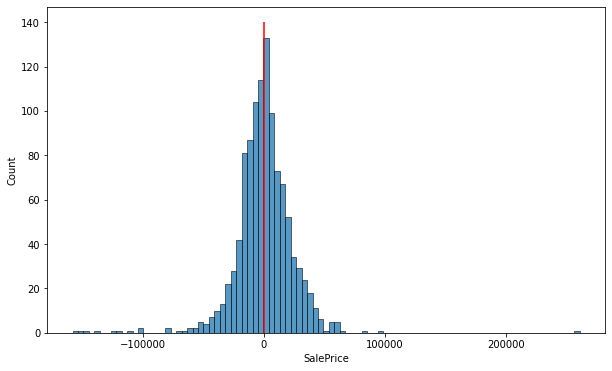

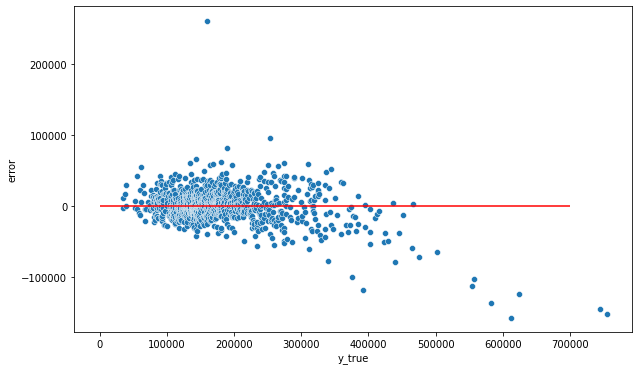

In [ ]:
plot_predictions(y_train, ridge_pipeline.predict(X_train))

In [ ]:
rd_test = ridge_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': ridge_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - ridge_pipeline.predict(X_test),
})

results.head()

,prediction,true_value,difference
1260,185526.412446,181000,-4526.412446
274,136283.783412,124500,-11783.783412
51,140577.559007,114500,-26077.559007
117,148801.144422,155000,6198.855578
789,210173.054337,187500,-22673.054337



        MSE: 338236587.7409624
        RMSE: 18391.20952360019
        MAE: 13010.605657499447
        R_SQR: 0.9355910936518872
        EXV: 0.9355910936518872
        ME: 93140.96524787252
        RMSLE: 0.10206633096073607
        
496294.2907984772 56535.69912340984


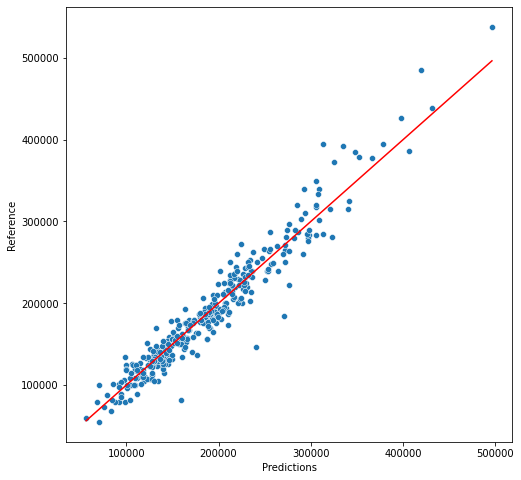

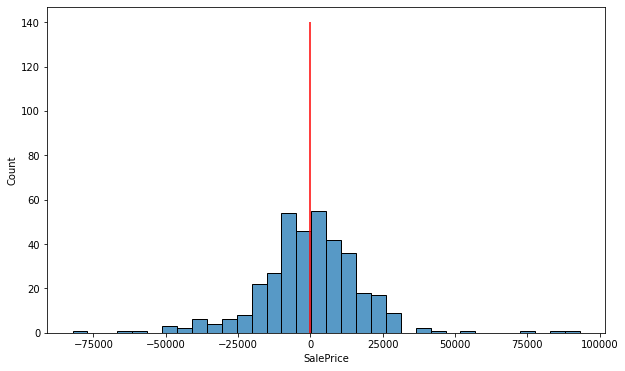

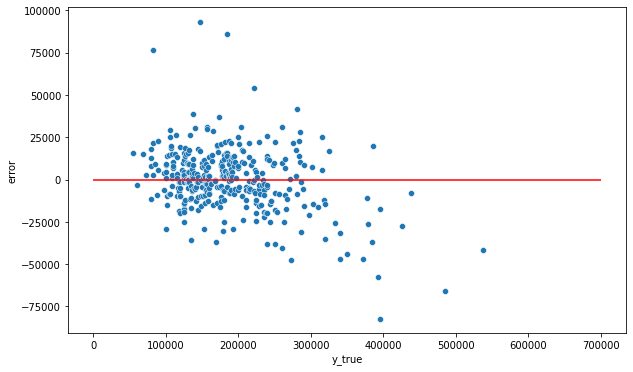

In [ ]:
plot_predictions(y_test, ridge_pipeline.predict(X_test))


Lasso Regression

In [ ]:
lasso_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', Ridge())
])

ls = lasso_pipeline.fit(X_train, y_train)


        MSE: 594558882.7568368
        RMSE: 24383.578136869837
        MAE: 16015.339341686707
        R_SQR: 0.9105591710167575
        EXV: 0.9105591710167577
        ME: 260981.2872974649
        RMSLE: 0.1245649989998451
        
601948.2479576308 34900


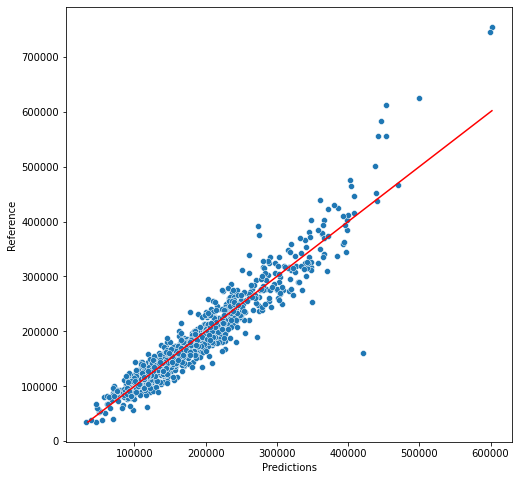

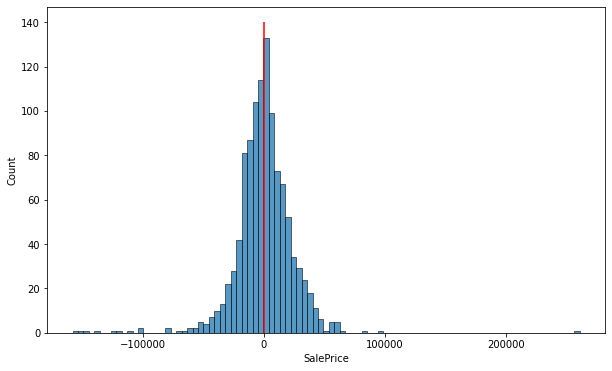

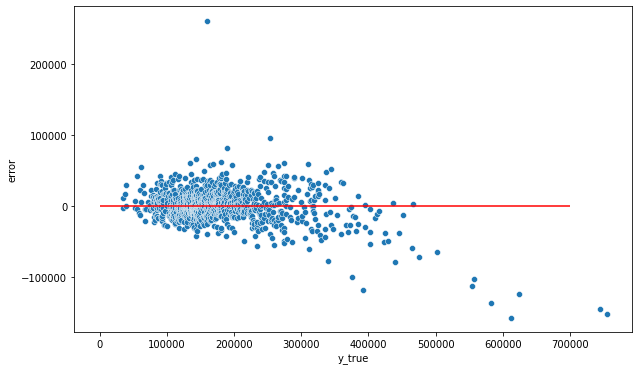

In [ ]:
plot_predictions(y_train, lasso_pipeline.predict(X_train))

In [ ]:
ls_test = lasso_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': lasso_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - lasso_pipeline.predict(X_test),
})

results.head()

,prediction,true_value,difference
1260,185526.412446,181000,-4526.412446
274,136283.783412,124500,-11783.783412
51,140577.559007,114500,-26077.559007
117,148801.144422,155000,6198.855578
789,210173.054337,187500,-22673.054337



        MSE: 338236587.7409624
        RMSE: 18391.20952360019
        MAE: 13010.605657499447
        R_SQR: 0.9355910936518872
        EXV: 0.9355910936518872
        ME: 93140.96524787252
        RMSLE: 0.10206633096073607
        
496294.2907984772 56535.69912340984


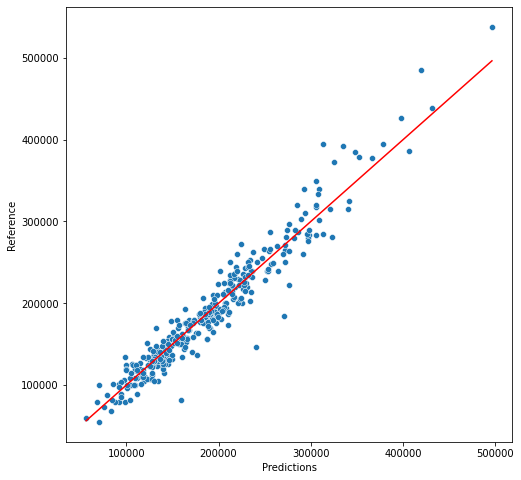

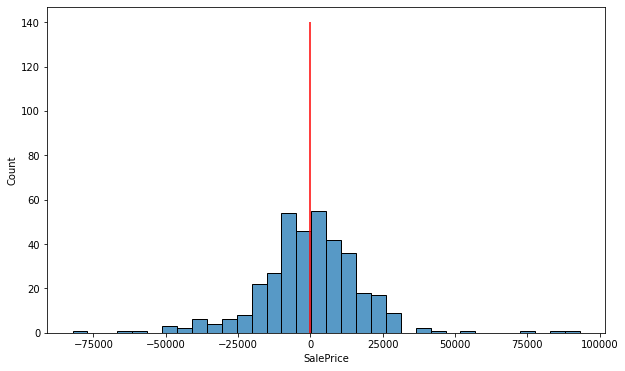

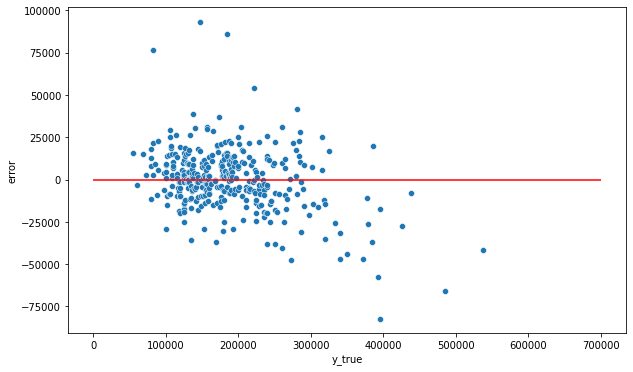

In [ ]:
plot_predictions(y_test, lasso_pipeline.predict(X_test))

Loading the Test Data

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [ ]:
final_submission = test.drop(test.columns.difference(cat_col + num_col), axis=1)

Random Forest Regressor Model Fit Test Data

In [ ]:
#rf = rf_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X, np.log(y))

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'GrLivArea', 'FullBath',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea']),
                                        

In [ ]:
SalePricePreds = np.exp(rf_pipeline.predict(final_submission))

In [ ]:
#Create new model DF
submission_file = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': SalePricePreds
}).to_csv('lvsubmission.csv', index=None)

In [ ]:
#Load submission file from computer
from google.colab import files
uploaded = files.upload()

Saving lvsubmission.csv to lvsubmission (1).csv


In [ ]:
import io
lvpredict = pd.read_csv(io.BytesIO(uploaded['lvsubmission.csv']))
lvpredict

,Id,SalePrice
0,1461,122817.868557
1,1462,146331.924248
2,1463,176489.165834
3,1464,187940.742425
4,1465,209550.053486
...,...,...
1454,2915,83261.514430
1455,2916,85484.388237
1456,2917,146430.881140
1457,2918,112439.142531


# Conclusion

Upon preliminary data cleaning and analysis, the initial hypothesis of house size (GrLivArea) did turn out to be highly correlative with SalePrice. In addition to GrLivArea, OverallQual, YearBuilt, YearRemodAdd, TotalBsmtSF, 1stFirSF, FullBath, TotRmsAbvGrd, GarageCars, GarageArea are other important driving forces for price. Additionally, with creation of a new feature GrLivGarageArea (which combined both GrLivArea and GarageArea), there is a strong correlation between that metric and SalePrice of the house. Utilizing different types of modeling, the linear regression, Random Forest regression, Ridge and Lasso, the model with the least RMSE the highest R-squared of the model was Random Forest Regression model with a RMSE of only $12,215 and an R-squared above 0.97. The test data was run with the Random Forest regression model and the data was submitted to Kaggle in the House Regression competition. These data will be useful moving forward with additional analysis and modeling.